# Solving Linear Systems with the HHL Quantum Algorithm: A Theoretical-Practical Tutorial

## State Preparation

The first step in initializing any quantum algorithm is importing the necessary libraries for constructing and executing the circuit. These operations can be visualized in the box below.

In [ ]:
from qiskit import QuantumRegister,␣
,→QuantumCircuit, ClassicalRegister,␣
,→transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import␣
,→plot_bloch_multivector, plot_distribution
from qiskit.circuit.library import␣
,→UnitaryGate
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm

Next, it is necessary to declare the registers to be used in the circuit according to the general overview presented in the previous section. For the $q-c\ket{0}^{\otimes n}$, we use $n = 2$ qubits, while for $q-b\ket{0}_b$ and $q-a\ket{0}$, we use $1$ qubit each, resulting in a total of $4$ qubits. Since the measurements are performed on $q-a\ket{0}$ and $q-b\ket{0}_b$, we use $n_c=2$ classical bits for measurement.

In [ ]:
nc = 2
clock = 2
ancilla = 1
qr_clock1 = QuantumRegister(1, 'clock_1')
qr_clock2 = QuantumRegister(1, 'clock_2')
qr_b = QuantumRegister(1, 'b')
qr_ancilla = QuantumRegister(ancilla,␣
,→'ancilla')
cl = ClassicalRegister(nc, 'cl')
qc = QuantumCircuit(qr_ancilla, qr_clock1,␣
,→qr_clock2, qr_b, cl)

Once the algorithm has been correctly initialized, the state preparation is performed by applying a quantum operator that transforms $\ket{0}_b = (1 \ \ \ 0)^T$ into the state $\ket{1}_b = (0 \ \ \ 1)^T$. This can be done simply by applying the $X$ logic gate:

\begin{equation}
    X \ket{0}_b = \ket{1}_b = \ket{b}
\end{equation}

We then obtain:

\begin{equation}
    \ket{\varphi_1} = \ket{1} \ket{00} \ket{0}_{a}
\end{equation}

In the algorithm, this operation is performed by specifying the gate and the desired qubits, as shown in the box below.

In [ ]:
qc.x(qr_b)
qc.barrier()

It is worth noting that, at the end of each routine, we apply a barrier in the circuit to make it more organized.

## Quantum Phase Estimation

At this point, the QPE routine is applied to the quantum circuit, starting with a uniformly distributed superposition in the clock qubits using the Hadamard gate:

In [ ]:
qc.h(qr_clock1)
qc.h(qr_clock2)
qc.barrier()

Before applying the controlled unitary, we perform a basis change to the eigenvector basis of $A$. Given that $\ket{1}=\frac{1}{\sqrt{2}}(-\ket{u_1}+\ket{u_2})$, we have $b_1=-\frac{1}{\sqrt{2}}$ and $b_2=\frac{1}{\sqrt{2}}$. Thus:

\begin{equation}
    \begin{split}
        \ket{\varphi_2} &= \ket{1} \frac{1}{2}(\ket{00} + \ket{01} + \ket{10} + \ket{11})\ket{0}_{a} \\
        \ket{\varphi_2} &= \frac{1}{\sqrt{2}}(-\ket{u_1}\ket{00}-\ket{u_1}\ket{01}-\ket{u_1}\ket{10}-\ket{u_1}\ket{11} \\
        &+\ket{u_2}\ket{00}+\ket{u_2}\ket{01}+\ket{u_2}\ket{10}+\ket{u_2}\ket{11})
    \end{split}
\end{equation}

The next step is the application of the operator $e^{iAt}$ considering

\begin{equation} \label{eq:seq_U}
    U^l \ket{b} = UUU \dots U \ket{b}= \left( e^{2 \pi i \theta}\right)^l \ket{b} = e^{2 \pi i \theta \cdot l} \ket{b}
\end{equation}

where each clock qubit controls a part of the time evolution. To achieve this, we use controlled logic gates so that the rotations are chosen based on the spectral decomposition of matrix $A$, whose transformation matrix is written as

\begin{equation}
    V = \begin{pmatrix}
\frac{1}{\sqrt{2}} &  \frac{1}{\sqrt{2}} \\
-\frac{1}{\sqrt{2}} &  \frac{1}{\sqrt{2}}\\
\end{pmatrix}
\end{equation}

In this context, the operator $U$ must have its diagonal representation defined as

\begin{equation} \label{eq:U_d}
    U_{D} = \begin{pmatrix}
    e^{i\lambda_1t} & 0 \\
    0 &  e^{i\lambda_2t}\\
\end{pmatrix}
\end{equation}

Note that the condition for the operator $\tilde \lambda_j = \tilde N\lambda_jt/2\pi$ to be an integer is satisfied for certain values of $t$. Choosing $t = \pi/2$, we obtain ${\tilde \lambda_1 = \lambda_1 =  1, \tilde \lambda_2 = \lambda_2 =2 }$, knowing that the diagonal representation of $U$ is given by

\begin{equation}
    U_{D} = \begin{pmatrix}
    e^{i\lambda_1t} & 0 \\
    0 &  e^{i\lambda_2t}\\
\end{pmatrix}
\end{equation}

which will then be rewritten as

\begin{equation}
    U_{d} = \begin{pmatrix}
    i & 0 \\
    0 &  -1\\
    \end{pmatrix}
\end{equation}

Finally, we can write $U$ in the basis of $A$ using the transformation matrix $U = VU_dV^{-1}$, resulting in

\begin{equation} \label{eq:1}
    U = \frac{1}{2}\begin{pmatrix}
    -1 + i & 1+i \\
    1+i &  -1+i\\
    \end{pmatrix}
\end{equation}

The process of obtaining higher-order unitary operators is thus reduced to $U^l = VU_d^lV^{-1}$. For $n=2$ c-qubits, $l=2$ is sufficient to provide an acceptable precision for the algorithm, so that $U^2$ is then written as

\begin{equation}
    U^2 = \begin{pmatrix}
    0 & -1 \\
    -1 &  0\\
    \end{pmatrix}
\end{equation}


In the simulation, the application of this operator can be considered by mapping the necessary angles for its implementation. A direct option for preparing unitary operators is the logic gate

\begin{equation}
U(\theta, \phi, \gamma, \lambda) =
\begin{pmatrix}
e^{i\gamma} \cos(\theta/2) & -e^{i(\gamma + \lambda)} \cos(\theta/2) \\
e^{i(\gamma + \phi)} \cos(\theta/2) & e^{i(\gamma + \phi + \lambda)} \cos(\theta/2)
\end{pmatrix}.
\end{equation}

Setting $\theta = \pi/2, \phi = -\pi/2, \gamma = 3\pi/4, \lambda=\pi/2$, we verify the correspondence with the operator $U$ defined in the form of $U$ in the basis of $A$. For $\theta = \pi, \phi = \pi, \gamma = 0, \lambda=0$, we then obtain $U^2$. Thus, the application of these operators in the circuit reduces to adding angles in the circuit through the controlled version of the $U(\theta, \phi, \gamma, \lambda)$ gate, as shown in the box below.

In [ ]:
qc.cu(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4,␣
,→qr_clock1, qr_b[0])
qc.cu(np.pi, np.pi, 0, 0, qr_clock2, qr_b[0])
qc.barrier()

After applying the controlled unitary operations, the state is then written as

\begin{equation}
    \begin{split}
        \ket{\varphi_3} &=  \frac{1}{2\sqrt{2}}(-\ket{u_1}\ket{00} - i\ket{u_1}\ket{01} + \ket{u_1}\ket{10} + i\ket{u_1}\ket{11} \\
        &+\ket{u_2}\ket{00} - \ket{u_2}\ket{01} + \ket{u_2}\ket{10} - \ket{u_2}\ket{11}) \ket{0}_a
    \end{split}
\end{equation}

Next, we apply the \textit{Inverse Quantum Fourier Transform}, which is responsible for converting the Fourier basis into the computational basis. The corresponding code can be seen in the box below.

In [ ]:
qc.h(qr_clock2)
qc.cp(-np.pi/2, qr_clock1, qr_clock2)
qc.h(qr_clock1)
qc.swap(qr_clock1, qr_clock2)
qc.barrier()

After applying $QFT^{\dagger}$, the resulting state is

\begin{equation*}
    \ket{\varphi_4} = QFT^{\dagger} \ket{\varphi_3}
\end{equation*}

\begin{equation}
\begin{split}
    \ket{\varphi_4} = \frac{1}{\sqrt{2}}\left(-\ket{u_1}\ket{01} + \ket{u_2}\ket{10}\right)\ket{0}_a
\end{split}
\end{equation}

## Ancilla Quantum Encoding

Here, we use controlled rotations based on $R_Y(\theta)$, which increase the probability of the ancilla qubit being observed in state $\ket{1}$. Equation \ref{eq:theta} provides a direct relationship between the decoded eigenvalues and the angles, given by

\begin{equation}
    \theta (\tilde \lambda_1) = 2\arcsin{(1/1)} = \pi
\end{equation}

\begin{equation}
   \theta (\tilde \lambda_2) = 2\arcsin{(1/2)} = \pi/3
\end{equation}

Similar to the previous step, these angles are substituted into a controlled version of the $R_Y$ gate, as shown below.

In [ ]:
qc.cry(np.pi, qr_clock1, qr_ancilla[0])
qc.cry(np.pi/3, qr_clock2, qr_ancilla[0])
qc.barrier()

Additionally, this is also the stage where the ancilla qubit is measured, with its result stored in the classical register. Considering Eq. \ref{eq:17}, this step results in

\begin{equation}
    \begin{split}
        \ket{\varphi_6} &= \sqrt{\frac{8}{5}} \left(-\frac{1}{\sqrt{2}}\ket{u_1}\ket{01}\ket{1}_a \right.\\
        & \left. + \frac{1}{2\sqrt{2}}\ket{u_2}\ket{10}\ket{1}_a\right)
    \end{split}
\end{equation}

At this stage, we obtain a state close to the expected one, but it cannot be directly measured in the computational basis, as the target state $\ket{x}$ is entangled with the \textit{c-qubits}.

## Inverse Quantum Phase Estimation

Now, we apply $QPE^{\dagger}$ to enable the correct measurement of $\ket{x}$ in the computational basis. For this purpose, QFT is applied to encode the information in frequency, as shown in the box below.

In [ ]:
qc.swap(qr_clock1, qr_clock2)
qc.h(qr_clock1)
qc.cp(np.pi/2, qr_clock1, qr_clock2)
qc.h(qr_clock2)
qc.barrier()
qc.measure(qr_ancilla, cl[ancilla:])
qc.barrier()

The resulting state is

\begin{equation}
    \begin{split}
        \ket{\varphi_7} &= \sqrt{\frac{8}{5}}\left(-\frac{1}{\sqrt{2}}\ket{u_1}\frac{1}{2}\left(\ket{00} + i\ket{01} - \ket{10} 
        \right. \right.\\
        &\left. -i\ket{11}\right)\ket{1}_a + \frac{1}{2\sqrt{2}}\ket{u_2}\frac{1}{2}\left(\ket{00} - \ket{01} \right.\\
        &\left. \left.
        + \ket{10} - \ket{11}\right)\right)\ket{1}_a
    \end{split}
\end{equation}

Next, we apply inverse evolution ($e^{-iAt}$), which restores the initial state. At this point, the inverse matrices can be computed following the same logic as the unitary applications, but considering $U^{-l} = VU_d^{-l}V$. Thus, we obtain

\begin{equation}
    U^{-1} = \begin{pmatrix}
    -1-i & 1-i \\
    1-i &  -1-i \\
    \end{pmatrix}
\end{equation}

This can be implemented by setting $\theta = \pi/2$, $\phi = \pi/2$, $\gamma = -3\pi/4$, and $\lambda=-\pi/2$. Note that $U^2 = U^{-2}$, so we set $\theta = \pi$, $\phi = \pi$, $\gamma = 0$, and $\lambda=0$. These operations are implemented in the box below.

In [ ]:
qc.cu(np.pi, np.pi, 0, 0, qr_clock2, qr_b[0])
qc.cu(np.pi/2, np.pi/2, -np.pi/2, -3*np.pi/
,→4, qr_clock1, qr_b[0])
qc.barrier()

For the inverse controlled rotation, the state will be multiplied by $e^{-i\lambda_jt}$, $e^{-i2\lambda_jt}$ and $e^{-i3\lambda_jt}$. Given that $e^{-i\lambda_1t}=-i$, $e^{-i2\lambda_1t}=-1$, $e^{-i3\lambda_1t}=i$ $e^{-i\lambda_2t}=-1$, $e^{-i2\lambda_2t}=1$ and $e^{-i3\lambda_2t}=-1$, we will have the state given by:

\begin{equation}
    \begin{split}
        \ket{\varphi_8} &= \sqrt{\frac{8}{5}}\left(-\frac{1}{\sqrt{2}}\ket{u_1}\frac{1}{2}(\ket{00} + \ket{01} + \ket{10} + \ket{11}\right)\ket{1}_a \\
        &+ \frac{1}{2\sqrt{2}}\ket{u_2}\frac{1}{2}\left(\ket{00} + \ket{01} + \ket{10} + \ket{11}\right)\ket{1}_a \\
        &= \frac{1}{2}\sqrt{\frac{8}{5}}\left(-\frac{1}{(1)\sqrt{2}}\ket{u_1}\frac{1}{(2)\sqrt{2}}\ket{u_2} \right)\left(\ket{00} +  \ket{01} \right.
        \\ 
        & \left. + \ket{10} + \ket{11}\right)\ket{1}_a 
    \end{split}
\end{equation}

In the last step, we use the Hadamard gate again, finalizing the circuit with the inversion of the uniformly distributed superposition applied to the clock qubits during the QPE routine, and it should be applied as shown in the box below.

In [ ]:
qc.h(qr_clock1)
qc.h(qr_clock2)
qc.barrier()

This results in the state given by:

\begin{equation}
        \ket{\varphi_9} = \sqrt{\frac{8}{5}} \left( -\frac{1}{(1)\sqrt{2}}\ket{u_1}+\frac{1}{(2)\sqrt{2}}\ket{u_2} \right) \ket{00}\ket{1}_a
\end{equation}

After substituting in the computational basis of $\ket{u_1}=\frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}$ e $\ket{u_2}=\frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}$, we will have:

\begin{equation}
    \ket{\varphi_9} = \left(-\frac{\sqrt{10}}{10}\ket{0} + \frac{3\sqrt{10}}{10}\ket{1}\right)\ket{00}\ket{1}_a    
\end{equation}

## Numerical Results

After compiling the necessary routines for the actual functioning of the algorithm, it is then possible to evaluate the quality of its results. For this, we must choose the architecture used (simulator or real quantum computer) and the number of measurements (shots) to finally plot the probability distribution of the measurement, as shown in the box. In this case, the selected environment was the AerSimulator(), a noise-free simulator based on measurements.

In [ ]:
qc.barrier()
qc.measure(qr_b, cl[:ancilla])
simulator = AerSimulator()
new_circuit = transpile(qc, simulator)
job = simulator.run(new_circuit, shots =␣
,→4096)
result = job.result()
counts = result.get_counts()
total_shots = sum(counts.values())
probabilities = {state: count / total_shots␣
,→for state, count in counts.items()}
plot_distribution = (counts)

The results should be

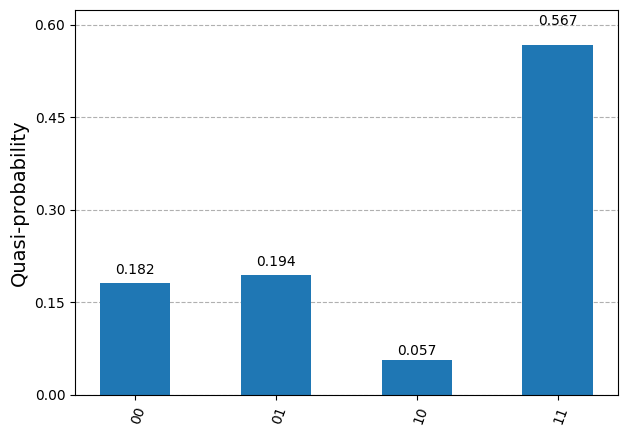

### Generated quantum circuit:

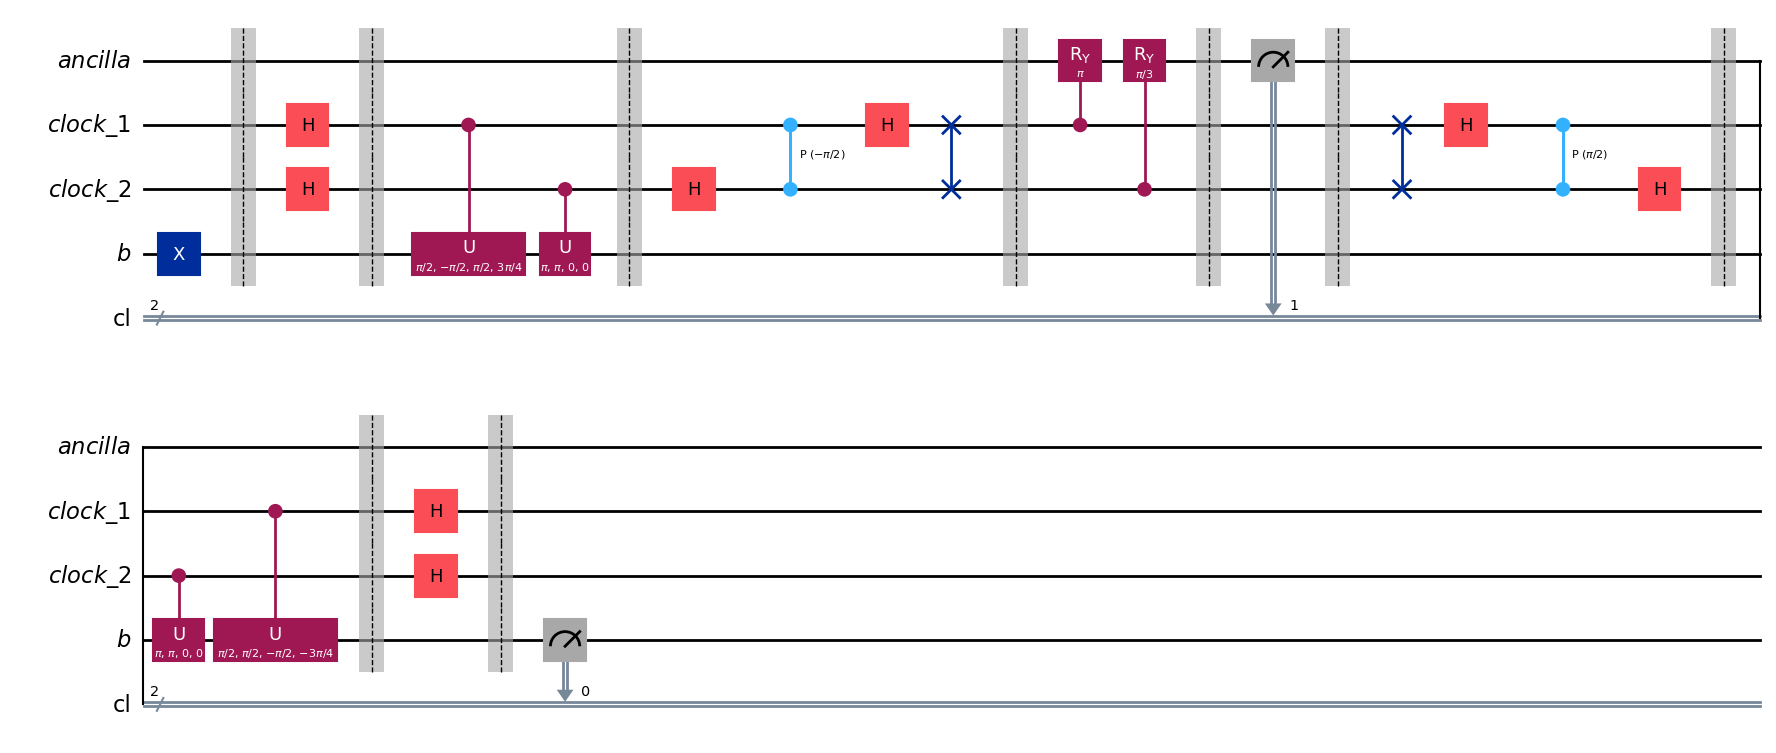